In [1]:
import numpy as np
from numpy import array
import pandas as pd
import re
import string as str

import urllib.request
from bs4 import BeautifulSoup

import spacy
import nltk
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags

from nltk.corpus import stopwords                   # Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from nltk.stem import WordNetLemmatizer             # WordNet

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from gensim.models import Word2Vec                                   #For Word2Vec

from pprint import pprint
from collections import Counter
from tqdm import tqdm

import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def url_to_string(url):
    #res = requests.get(url)
    #html = res.text
    html = urllib.request.urlopen(url)
    
    soup = BeautifulSoup(html, 'html.parser')
    
    # kill all script, style and other elements
    for script in soup(['script', 'style', 'button', 'a']):
        script.extract()

    # get text
    text = soup.get_text()
        
    # break into lines and remove leading and trailing space on each
    lines = [line.strip() for line in text.splitlines()]
    # break multi-headlines into a line each
    chunks = [phrase.strip() for line in lines for phrase in line.split("  ")]
    # drop blank lines
    text = '\n'.join([chunk for chunk in chunks if chunk])
    
    return text
url = 'https://insights.hsbc.co.uk/content/hsbc/gb/en_gb/wealth/insights/macro-outlook/china-insights/china-insights-2019-09-11/'
#test_url = 'https://www.nytimes.com/2018/08/13/us/politics/peter-strzok-fired-fbi.html?hp&action=click&pgtype=Homepage&clickSource=story-heading&module=first-column-region&region=top-news&WT.nav=top-news'
text = url_to_string(url)
print(text)

China Insights – HSBC Insights
We use cookies
We use cookies to give you the best possible experience on our website. By continuing to browse this site, you give consent for cookies to be used. For more details, please read our Cookie Policy.
.
Language
English
Everyday banking
Accounts & services
Borrowing
Loans & mortgages
Investing
Products & planning
Insurance
Property & family
Help
Support & security
Everyday banking
Accounts & services
Borrowing
Loans & mortgages
Investing
Products & planning
Insurance
Property & family
Help
Support & security
UK
Language
English
Language
Top of main content
China Insights
|
Monthly update on Chinese markets
11/09/2019
This article is about
Equities
China
Summary
China’s property prices have continued to rise so far this year, shrugging off worries about a slowing economy
and prolonged trade conflicts with the US
However, soaring prices have complicated efforts to spur growth as policy makers monitor downside risks
New interest rate benchmark sho

In [3]:
df = pd.DataFrame({'Sentences':text.split('\n')})
df

,Sentences
0,China Insights – HSBC Insights
1,We use cookies
2,We use cookies to give you the best possible e...
3,.
4,Language
...,...
109,Help & support
110,Branch Finder
111,Our Service performance
112,About HSBC


In [4]:
df['Sentences'][43]

'homebuyers and small businesses'

In [5]:
train_df = df[44:106]
train_df.reset_index(drop=True, inplace=True)
train_df

,Sentences
0,China Property: A balancing act between growth...
1,China’s property prices have continued to rise...
2,"There are, however, signs that policymakers wa..."
3,"The National Development Reform Commission, th..."
4,The recent tightening in overseas funding chan...
...,...
57,This document is prepared by or on behalf of H...
58,This document is not prepared with any particu...
59,You should consult a professional adviser in y...
60,"No part of this document may be reproduced, st..."


In [6]:
# list of sentences
segment = []
for text in train_df['Sentences']:
    segment.append(re.split('[^0-9]["."][^0-9]', text))

sentences = [sent for sents in segment for sent in sents]
#sentences.sort()
sentences

['China Property: A balancing act between growth and reforms',
 'China’s property prices have continued to rise so far this year despite a prolonged trade conflict with the US.',
 'There are, however, signs that policymakers want to keep the runaway prices under control, with new tightening measures to rein in credit for both developers and homebuyers.',
 'The National Development Reform Commission, the country’s top economic planner, in July tightened the grip on the issuance of offshore debt, curtailing developers’ appetite for new debt issuanc',
 'Specifically, developers can only issue debt to refinance outstanding foreign-currency liabilities in the next 12 months, a move intended to cool land market auctions in the country.',
 'The recent tightening in overseas funding channels, mainly the offshore US dollar credit market, has followed the reining in of the trust financing channel in the onshore market, another major source of funding channel for the capital-intensive industry.',

In [7]:
# Tune some sentences in the passage
sentences[13] = ' '.join(sentences[13:16])
sentences.pop(15)
sentences.pop(14)
sentences

['China Property: A balancing act between growth and reforms',
 'China’s property prices have continued to rise so far this year despite a prolonged trade conflict with the US.',
 'There are, however, signs that policymakers want to keep the runaway prices under control, with new tightening measures to rein in credit for both developers and homebuyers.',
 'The National Development Reform Commission, the country’s top economic planner, in July tightened the grip on the issuance of offshore debt, curtailing developers’ appetite for new debt issuanc',
 'Specifically, developers can only issue debt to refinance outstanding foreign-currency liabilities in the next 12 months, a move intended to cool land market auctions in the country.',
 'The recent tightening in overseas funding channels, mainly the offshore US dollar credit market, has followed the reining in of the trust financing channel in the onshore market, another major source of funding channel for the capital-intensive industry.',

In [8]:
def preprocess(sentences):
    list_of_words = []
    for sent in sentences:
        # Convert all words to lowercase
        sent = sent.lower()

        # Remove numbers
        # sent = re.sub(r'\d+', '', sent)

        # Remove punctuation
        #sent = sent.translate(string.maketrans(','), string.punctuation)

        # Remove space
        sent = sent.strip()

        # Remove stop-words and Stemming
        stop_words = set(stopwords.words('english'))
        tokens = nltk.word_tokenize(sent)
        tokens_ = [i for i in tokens if not i in stop_words]
        
        stemmer = PorterStemmer()
        for token in tokens_:
            stems = stemmer.stem(token)
            list_of_words.append(stems)

        # Lemmatization with WordNet
    #    lemmatizer = WordNetLemmatizer()
    #    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    
        #list_of_words.append(words)

    return list_of_words
list_of_words = preprocess(sentences)
list_of_words

['china',
 'properti',
 ':',
 'balanc',
 'act',
 'growth',
 'reform',
 'china',
 '’',
 'properti',
 'price',
 'continu',
 'rise',
 'far',
 'year',
 'despit',
 'prolong',
 'trade',
 'conflict',
 'us',
 '.',
 ',',
 'howev',
 ',',
 'sign',
 'policymak',
 'want',
 'keep',
 'runaway',
 'price',
 'control',
 ',',
 'new',
 'tighten',
 'measur',
 'rein',
 'credit',
 'develop',
 'homebuy',
 '.',
 'nation',
 'develop',
 'reform',
 'commiss',
 ',',
 'countri',
 '’',
 'top',
 'econom',
 'planner',
 ',',
 'juli',
 'tighten',
 'grip',
 'issuanc',
 'offshor',
 'debt',
 ',',
 'curtail',
 'develop',
 '’',
 'appetit',
 'new',
 'debt',
 'issuanc',
 'specif',
 ',',
 'develop',
 'issu',
 'debt',
 'refin',
 'outstand',
 'foreign-curr',
 'liabil',
 'next',
 '12',
 'month',
 ',',
 'move',
 'intend',
 'cool',
 'land',
 'market',
 'auction',
 'countri',
 '.',
 'recent',
 'tighten',
 'oversea',
 'fund',
 'channel',
 ',',
 'mainli',
 'offshor',
 'us',
 'dollar',
 'credit',
 'market',
 ',',
 'follow',
 'rein',
 't

In [9]:
# POS tagging (input: list of words)
POS = nltk.pos_tag(list_of_words)

# Chunking
pattern = 'NP: {<DT>?<JJ>*<NN>}'

NPChunker = nltk.RegexpParser(pattern)
result = NPChunker.parse(POS)
print(result)
#result.draw()

(S
  (NP china/NN)
  (NP properti/NN)
  :/:
  (NP balanc/NN)
  (NP act/NN)
  (NP growth/NN)
  (NP reform/NN)
  (NP china/NN)
  ’/NNP
  (NP properti/NN)
  (NP price/NN)
  continu/NNS
  (NP rise/NN)
  far/RB
  (NP year/NN)
  (NP despit/NN)
  prolong/IN
  (NP trade/NN)
  (NP conflict/NN)
  us/PRP
  ./.
  ,/,
  (NP howev/NN)
  ,/,
  (NP sign/NN)
  (NP policymak/NN)
  want/VBP
  keep/VB
  (NP runaway/JJ price/NN)
  (NP control/NN)
  ,/,
  (NP new/JJ tighten/JJ measur/NN)
  (NP rein/NN)
  (NP credit/NN)
  develop/VB
  (NP homebuy/NN)
  ./.
  (NP nation/NN)
  develop/VB
  (NP reform/NN)
  (NP commiss/NN)
  ,/,
  countri/JJ
  ’/NNP
  (NP top/NN)
  (NP econom/NN)
  (NP planner/NN)
  ,/,
  (NP juli/NN)
  (NP tighten/JJ grip/NN)
  (NP issuanc/NN)
  (NP offshor/NN)
  (NP debt/NN)
  ,/,
  (NP curtail/NN)
  (NP develop/NN)
  ’/NNP
  appetit/VBZ
  (NP new/JJ debt/NN)
  (NP issuanc/NN)
  (NP specif/NN)
  ,/,
  develop/VB
  (NP issu/JJ debt/NN)
  (NP refin/NN)
  outstand/IN
  (NP foreign-curr/JJ liabil

In [10]:
# Named Entities Recognition
ne_tree = nltk.ne_chunk(POS)
print(ne_tree)

(S
  china/NN
  properti/NN
  :/:
  balanc/NN
  act/NN
  growth/NN
  reform/NN
  china/NN
  ’/NNP
  properti/NN
  price/NN
  continu/NNS
  rise/NN
  far/RB
  year/NN
  despit/NN
  prolong/IN
  trade/NN
  conflict/NN
  us/PRP
  ./.
  ,/,
  howev/NN
  ,/,
  sign/NN
  policymak/NN
  want/VBP
  keep/VB
  runaway/JJ
  price/NN
  control/NN
  ,/,
  new/JJ
  tighten/JJ
  measur/NN
  rein/NN
  credit/NN
  develop/VB
  homebuy/NN
  ./.
  nation/NN
  develop/VB
  reform/NN
  commiss/NN
  ,/,
  countri/JJ
  ’/NNP
  top/NN
  econom/NN
  planner/NN
  ,/,
  juli/NN
  tighten/JJ
  grip/NN
  issuanc/NN
  offshor/NN
  debt/NN
  ,/,
  curtail/NN
  develop/NN
  ’/NNP
  appetit/VBZ
  new/JJ
  debt/NN
  issuanc/NN
  specif/NN
  ,/,
  develop/VB
  issu/JJ
  debt/NN
  refin/NN
  outstand/IN
  foreign-curr/JJ
  liabil/NN
  next/JJ
  12/CD
  month/NN
  ,/,
  move/VBP
  intend/NN
  cool/NN
  land/NN
  market/NN
  auction/NN
  countri/NN
  ./.
  recent/JJ
  tighten/JJ
  oversea/NN
  fund/NN
  channel/NN
  ,/,
  

In [11]:
iob_tagged = tree2conlltags(result)
pprint(iob_tagged)

[('china', 'NN', 'B-NP'),
 ('properti', 'NN', 'B-NP'),
 (':', ':', 'O'),
 ('balanc', 'NN', 'B-NP'),
 ('act', 'NN', 'B-NP'),
 ('growth', 'NN', 'B-NP'),
 ('reform', 'NN', 'B-NP'),
 ('china', 'NN', 'B-NP'),
 ('’', 'NNP', 'O'),
 ('properti', 'NN', 'B-NP'),
 ('price', 'NN', 'B-NP'),
 ('continu', 'NNS', 'O'),
 ('rise', 'NN', 'B-NP'),
 ('far', 'RB', 'O'),
 ('year', 'NN', 'B-NP'),
 ('despit', 'NN', 'B-NP'),
 ('prolong', 'IN', 'O'),
 ('trade', 'NN', 'B-NP'),
 ('conflict', 'NN', 'B-NP'),
 ('us', 'PRP', 'O'),
 ('.', '.', 'O'),
 (',', ',', 'O'),
 ('howev', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('sign', 'NN', 'B-NP'),
 ('policymak', 'NN', 'B-NP'),
 ('want', 'VBP', 'O'),
 ('keep', 'VB', 'O'),
 ('runaway', 'JJ', 'B-NP'),
 ('price', 'NN', 'I-NP'),
 ('control', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('new', 'JJ', 'B-NP'),
 ('tighten', 'JJ', 'I-NP'),
 ('measur', 'NN', 'I-NP'),
 ('rein', 'NN', 'B-NP'),
 ('credit', 'NN', 'B-NP'),
 ('develop', 'VB', 'O'),
 ('homebuy', 'NN', 'B-NP'),
 ('.', '.', 'O'),
 ('nation', 'N

 ('part', 'NN', 'B-NP'),
 ('document', 'NN', 'B-NP'),
 ('may', 'MD', 'O'),
 ('reproduc', 'VB', 'O'),
 (',', ',', 'O'),
 ('store', 'NN', 'B-NP'),
 ('retriev', 'NN', 'B-NP'),
 ('system', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('transmit', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('form', 'NN', 'B-NP'),
 ('mean', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('electron', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('mechan', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('photocopi', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('record', 'NN', 'B-NP'),
 ('otherwis', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('without', 'IN', 'O'),
 ('prior', 'JJ', 'O'),
 ('written', 'VBN', 'O'),
 ('permiss', 'JJ', 'B-NP'),
 ('hsbc', 'NN', 'I-NP'),
 ('uk', 'JJ', 'B-NP'),
 ('bank', 'NN', 'I-NP'),
 ('plc', 'NN', 'B-NP'),
 ('.', '.', 'O'),
 ('capit', 'NN', 'B-NP'),
 ('ri', 'NN', 'B-NP'),
 ('elig', 'FW', 'O'),
 ('criteria', 'NNS', 'O'),
 ('term', 'NN', 'B-NP'),
 ('appli', 'NN', 'B-NP')]


In [12]:
# Run NLP model
#spacy_nlp = spacy.load('en')
nlp = spacy.load('en_core_web_sm') # load model

# Merge sentences to passage
passage = '.'.join(sentences)

# create a spaCy object 
doc = nlp(passage)

# print token, dependency, POS tag 
for tok in doc:
    print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

China --> compound --> PROPN
Property --> ROOT --> PROPN
: --> punct --> PUNCT
A --> det --> DET
balancing --> amod --> NOUN
act --> ROOT --> NOUN
between --> prep --> ADP
growth --> pobj --> NOUN
and --> cc --> CCONJ
reforms --> conj --> NOUN
. --> punct --> PUNCT
China --> compound --> PROPN
’s --> compound --> PART
property --> compound --> NOUN
prices --> nsubj --> NOUN
have --> aux --> AUX
continued --> ROOT --> VERB
to --> aux --> PART
rise --> xcomp --> VERB
so --> advmod --> ADV
far --> advmod --> ADV
this --> det --> DET
year --> npadvmod --> NOUN
despite --> prep --> SCONJ
a --> det --> DET
prolonged --> amod --> ADJ
trade --> compound --> NOUN
conflict --> pobj --> NOUN
with --> prep --> ADP
the --> det --> DET
US --> pobj --> PROPN
.. --> punct --> PUNCT
There --> expl --> PRON
are --> ROOT --> AUX
, --> punct --> PUNCT
however --> advmod --> ADV
, --> punct --> PUNCT
signs --> attr --> NOUN
that --> mark --> SCONJ
policymakers --> nsubj --> NOUN
want --> acl --> VERB
to --

inflating --> pcomp --> VERB
property --> compound --> NOUN
prices --> dobj --> NOUN
. --> punct --> PUNCT
The --> det --> DET
PBoC --> nsubj --> NOUN
on --> prep --> ADP
August --> pobj --> PROPN
17 --> nummod --> NUM
revamped --> ROOT --> VERB
its --> poss --> PRON
tool --> compound --> NOUN
kit --> dobj --> NOUN
with --> prep --> ADP
a --> det --> DET
new --> amod --> ADJ
benchmark --> amod --> ADJ
interest --> compound --> NOUN
rat --> pobj --> NOUN
. --> punct --> PUNCT
The --> det --> DET
loan --> nmod --> NOUN
prime --> compound --> ADJ
rate --> nsubj --> NOUN
, --> punct --> PUNCT
or --> cc --> CCONJ
LPR --> conj --> PROPN
, --> punct --> PUNCT
has --> aux --> AUX
become --> ROOT --> VERB
the --> det --> DET
reference --> compound --> NOUN
rate --> attr --> NOUN
for --> prep --> ADP
banks --> nsubj --> NOUN
pricing --> pcomp --> VERB
corporate --> amod --> ADJ
loans --> dobj --> NOUN
and --> cc --> CCONJ
household --> compound --> NOUN
mortgages --> conj --> NOUN
.. --> punct -

% --> quantmod --> NOUN
to --> quantmod --> PART
10 --> nummod --> NUM
% --> pobj --> NOUN
, --> punct --> PUNCT
on --> prep --> ADP
USD75 --> compound --> PROPN
billion --> pobj --> NUM
of --> prep --> ADP
US --> compound --> PROPN
goods --> pobj --> NOUN
that --> nsubj --> PRON
include --> relcl --> VERB
soybeans --> dobj --> NOUN
and --> cc --> CCONJ
frozen --> amod --> ADJ
por --> conj --> NOUN
. --> punct --> PUNCT
Beijing --> compound --> PROPN
’s --> compound --> PART
retaliatory --> compound --> ADJ
move --> nsubj --> NOUN
was --> ROOT --> AUX
a --> det --> DET
response --> attr --> NOUN
to --> prep --> ADP
the --> det --> DET
US --> compound --> PROPN
decision --> pobj --> NOUN
earlier --> advmod --> ADV
in --> prep --> ADP
August --> pobj --> PROPN
to --> aux --> PART
impose --> advcl --> VERB
a --> det --> DET
10 --> nummod --> NUM
% --> compound --> NOUN
tariff --> dobj --> NOUN
on --> prep --> ADP
USD300 --> compound --> NUM
billion --> nummod --> NUM
worth --> pobj --> NO

Chinese --> amod --> ADJ
bonds --> pobj --> NOUN
topped --> ROOT --> VERB
RMB2 --> compound --> PROPN
trillion --> dobj --> NUM
for --> prep --> ADP
the --> det --> DET
first --> amod --> ADJ
time --> pobj --> NOUN
in --> prep --> ADP
July --> pobj --> PROPN
, --> punct --> PUNCT
according --> prep --> VERB
to --> prep --> ADP
data --> pobj --> NOUN
compiled --> acl --> VERB
by --> agent --> ADP
clearing --> pcomp --> VERB
houses --> dobj --> NOUN
China --> compound --> PROPN
Central --> compound --> PROPN
Depository --> dobj --> PROPN
and --> cc --> CCONJ
Clearing --> conj --> PROPN
and --> cc --> CCONJ
Shanghai --> compound --> PROPN
Clearing --> compound --> PROPN
Hous --> conj --> PROPN
. --> punct --> PUNCT
Foreign --> amod --> ADJ
interest --> nsubjpass --> NOUN
in --> prep --> ADP
Chinese --> amod --> ADJ
bonds --> pobj --> NOUN
is --> auxpass --> AUX
partly --> advmod --> ADV
driven --> ROOT --> VERB
by --> agent --> ADP
Bloomberg --> compound --> PROPN
Barclays --> compound --

general --> amod --> ADJ
circulation --> pobj --> NOUN
and --> cc --> CCONJ
info --> compound --> NOUN
rma --> compound --> PROPN
tion --> compound --> NOUN
purposes --> compound --> NOUN
onl --> conj --> VERB
. --> punct --> PUNCT
HSBC --> nsubj --> PROPN
has --> aux --> AUX
prepared --> ROOT --> VERB
or --> cc --> CCONJ
arranged --> conj --> VERB
for --> prep --> ADP
the --> det --> DET
content --> pobj --> NOUN
of --> prep --> ADP
this --> det --> DET
document --> pobj --> NOUN
based --> acl --> VERB
on --> prep --> ADP
publicly --> advmod --> ADV
available --> amod --> ADJ
information --> pobj --> NOUN
at --> prep --> ADP
the --> det --> DET
time --> pobj --> NOUN
of --> prep --> ADP
preparation --> pobj --> NOUN
from --> prep --> ADP
sources --> pobj --> NOUN
it --> nsubj --> PRON
believes --> conj --> VERB
to --> aux --> PART
be --> xcomp --> AUX
reliable --> acomp --> ADJ
but --> cc --> CCONJ
it --> nsubj --> PRON
has --> aux --> AUX
not --> neg --> PART
independently --> advmod

In [13]:
# Type of each entities
for element in doc.ents:
    print('Type: %s, Value: %s' % (element.label_, element))

Type: GPE, Value: China
Type: GPE, Value: China
Type: DATE, Value: this year
Type: GPE, Value: US
Type: ORG, Value: The National Development Reform Commission
Type: DATE, Value: July
Type: DATE, Value: the next 12 months
Type: GPE, Value: US
Type: CARDINAL, Value: 70
Type: PERCENT, Value: 0.6%
Type: DATE, Value: July
Type: DATE, Value: the previous month
Type: CARDINAL, Value: 51
Type: DATE, Value: monthly
Type: ORG, Value: the National Bureau of Statistic
Type: PERCENT, Value: 9.7%
Type: DATE, Value: a year
Type: DATE, Value: year
Type: DATE, Value: July
Type: DATE, Value: this year
Type: PERCENT, Value: 10.3%
Type: DATE, Value: June
Type: DATE, Value: the first seven months
Type: PERCENT, Value: 0.4%
Type: PERCENT, Value: 1 %
Type: DATE, Value: the first six months
Type: DATE, Value: the year
Type: DATE, Value: this year
Type: DATE, Value: August
Type: ORG, Value: the People’s Bank of China
Type: DATE, Value: each month
Type: PERSON, Value: Yi Gang
Type: DATE, Value: August 17
Type: 

In [14]:
for element in doc.ents:
    print('Type: %s, Value: %s' % (element.label_, element))

Type: GPE, Value: China
Type: GPE, Value: China
Type: DATE, Value: this year
Type: GPE, Value: US
Type: ORG, Value: The National Development Reform Commission
Type: DATE, Value: July
Type: DATE, Value: the next 12 months
Type: GPE, Value: US
Type: CARDINAL, Value: 70
Type: PERCENT, Value: 0.6%
Type: DATE, Value: July
Type: DATE, Value: the previous month
Type: CARDINAL, Value: 51
Type: DATE, Value: monthly
Type: ORG, Value: the National Bureau of Statistic
Type: PERCENT, Value: 9.7%
Type: DATE, Value: a year
Type: DATE, Value: year
Type: DATE, Value: July
Type: DATE, Value: this year
Type: PERCENT, Value: 10.3%
Type: DATE, Value: June
Type: DATE, Value: the first seven months
Type: PERCENT, Value: 0.4%
Type: PERCENT, Value: 1 %
Type: DATE, Value: the first six months
Type: DATE, Value: the year
Type: DATE, Value: this year
Type: DATE, Value: August
Type: ORG, Value: the People’s Bank of China
Type: DATE, Value: each month
Type: PERSON, Value: Yi Gang
Type: DATE, Value: August 17
Type: 

In [15]:
pprint([(X.text, X.label_) for X in doc.ents])

[('China', 'GPE'),
 ('China', 'GPE'),
 ('this year', 'DATE'),
 ('US', 'GPE'),
 ('The National Development Reform Commission', 'ORG'),
 ('July', 'DATE'),
 ('the next 12 months', 'DATE'),
 ('US', 'GPE'),
 ('70', 'CARDINAL'),
 ('0.6%', 'PERCENT'),
 ('July', 'DATE'),
 ('the previous month', 'DATE'),
 ('51', 'CARDINAL'),
 ('monthly', 'DATE'),
 ('the National Bureau of Statistic', 'ORG'),
 ('9.7%', 'PERCENT'),
 ('a year', 'DATE'),
 ('year', 'DATE'),
 ('July', 'DATE'),
 ('this year', 'DATE'),
 ('10.3%', 'PERCENT'),
 ('June', 'DATE'),
 ('the first seven months', 'DATE'),
 ('0.4%', 'PERCENT'),
 ('1 %', 'PERCENT'),
 ('the first six months', 'DATE'),
 ('the year', 'DATE'),
 ('this year', 'DATE'),
 ('August', 'DATE'),
 ('the People’s Bank of China', 'ORG'),
 ('each month', 'DATE'),
 ('Yi Gang', 'PERSON'),
 ('August 17', 'DATE'),
 ('LPR', 'ORG'),
 ('monthly', 'DATE'),
 ('LPR', 'ORG'),
 ('the one year', 'DATE'),
 ('MLF', 'ORG'),
 ('August 20', 'DATE'),
 ('the one year', 'DATE'),
 ('4.25%', 'PERCENT'

In [16]:
pprint([(X, X.ent_iob_, X.ent_type_) for X in doc])
# B = begins an entity, I = inside an entity, O = outside the entity

[(China, 'B', 'GPE'),
 (Property, 'O', ''),
 (:, 'O', ''),
 (A, 'O', ''),
 (balancing, 'O', ''),
 (act, 'O', ''),
 (between, 'O', ''),
 (growth, 'O', ''),
 (and, 'O', ''),
 (reforms, 'O', ''),
 (., 'O', ''),
 (China, 'B', 'GPE'),
 (’s, 'O', ''),
 (property, 'O', ''),
 (prices, 'O', ''),
 (have, 'O', ''),
 (continued, 'O', ''),
 (to, 'O', ''),
 (rise, 'O', ''),
 (so, 'O', ''),
 (far, 'O', ''),
 (this, 'B', 'DATE'),
 (year, 'I', 'DATE'),
 (despite, 'O', ''),
 (a, 'O', ''),
 (prolonged, 'O', ''),
 (trade, 'O', ''),
 (conflict, 'O', ''),
 (with, 'O', ''),
 (the, 'O', ''),
 (US, 'B', 'GPE'),
 (.., 'O', ''),
 (There, 'O', ''),
 (are, 'O', ''),
 (,, 'O', ''),
 (however, 'O', ''),
 (,, 'O', ''),
 (signs, 'O', ''),
 (that, 'O', ''),
 (policymakers, 'O', ''),
 (want, 'O', ''),
 (to, 'O', ''),
 (keep, 'O', ''),
 (the, 'O', ''),
 (runaway, 'O', ''),
 (prices, 'O', ''),
 (under, 'O', ''),
 (control, 'O', ''),
 (,, 'O', ''),
 (with, 'O', ''),
 (new, 'O', ''),
 (tightening, 'O', ''),
 (measures, 'O',

 (,, 'O', ''),
 (the, 'O', ''),
 (introduction, 'O', ''),
 (in, 'O', ''),
 (August, 'B', 'DATE'),
 (of, 'O', ''),
 (a, 'O', ''),
 (new, 'O', ''),
 (benchmark, 'O', ''),
 (interest, 'O', ''),
 (rate, 'O', ''),
 (by, 'O', ''),
 (the, 'B', 'ORG'),
 (People, 'I', 'ORG'),
 (’s, 'I', 'ORG'),
 (Bank, 'I', 'ORG'),
 (of, 'I', 'ORG'),
 (China, 'I', 'ORG'),
 (will, 'O', ''),
 (start, 'O', ''),
 (to, 'O', ''),
 (have, 'O', ''),
 (a, 'O', ''),
 (gradual, 'O', ''),
 (impact, 'O', ''),
 (on, 'O', ''),
 (mortgage, 'O', ''),
 (payments, 'O', ''),
 (made, 'O', ''),
 (each, 'B', 'DATE'),
 (month, 'I', 'DATE'),
 (.., 'O', ''),
 (According, 'O', ''),
 (to, 'O', ''),
 (PBoC, 'O', ''),
 (Governor, 'O', ''),
 (Yi, 'B', 'PERSON'),
 (Gang, 'I', 'PERSON'),
 (,, 'O', ''),
 (the, 'O', ''),
 (government, 'O', ''),
 (wants, 'O', ''),
 (to, 'O', ''),
 (maintain, 'O', ''),
 (stability, 'O', ''),
 (in, 'O', ''),
 (the, 'O', ''),
 (property, 'O', ''),
 (market, 'O', ''),
 (and, 'O', ''),
 (will, 'O', ''),
 (ensure, 'O',

 (latest, 'O', ''),
 (round, 'O', ''),
 (of, 'O', ''),
 (trade, 'O', ''),
 (escalation, 'O', ''),
 (between, 'O', ''),
 (the, 'O', ''),
 (US, 'B', 'GPE'),
 (and, 'O', ''),
 (China, 'B', 'GPE'),
 (poses, 'O', ''),
 (a, 'O', ''),
 (heightened, 'O', ''),
 (threat, 'O', ''),
 (to, 'O', ''),
 (global, 'O', ''),
 (growt, 'O', ''),
 (., 'O', ''),
 (As, 'O', ''),
 (of, 'O', ''),
 (26, 'B', 'CARDINAL'),
 (th, 'O', ''),
 (August, 'B', 'DATE'),
 (,, 'O', ''),
 (the, 'O', ''),
 (former, 'O', ''),
 (and, 'O', ''),
 (latter, 'O', ''),
 (fell, 'O', ''),
 (6, 'B', 'PERCENT'),
 (%, 'I', 'PERCENT'),
 (and, 'O', ''),
 (5.3, 'B', 'PERCENT'),
 (%, 'I', 'PERCENT'),
 ((, 'O', ''),
 (USD, 'O', ''),
 (terms, 'O', ''),
 (), 'O', ''),
 (on, 'O', ''),
 (a, 'O', ''),
 (monthly, 'B', 'DATE'),
 (basis, 'O', ''),
 (,, 'O', ''),
 (respectively, 'O', ''),
 (., 'O', ''),
 (On, 'O', ''),
 (August, 'B', 'DATE'),
 (23, 'I', 'DATE'),
 (,, 'O', ''),
 (President, 'O', ''),
 (Donald, 'B', 'PERSON'),
 (Trump, 'I', 'PERSON'),
 (

 (for, 'O', ''),
 (any, 'O', ''),
 (failure, 'O', ''),
 (to, 'O', ''),
 (meet, 'O', ''),
 (such, 'O', ''),
 (forecasts, 'O', ''),
 (,, 'O', ''),
 (projections, 'O', ''),
 (or, 'O', ''),
 (target, 'O', ''),
 (., 'O', ''),
 (For, 'O', ''),
 (illustrative, 'O', ''),
 (purposes, 'O', ''),
 (only, 'O', ''),
 (.., 'O', ''),
 (Sector, 'O', ''),
 (views*.Source, 'O', ''),
 (:, 'O', ''),
 (Bloomberg, 'B', 'PERSON'),
 (,, 'O', ''),
 (HSBC, 'B', 'ORG'),
 (Global, 'I', 'ORG'),
 (Asset, 'I', 'ORG'),
 (Management, 'I', 'ORG'),
 (,, 'O', ''),
 (as, 'O', ''),
 (of, 'O', ''),
 (August, 'B', 'DATE'),
 (2019, 'I', 'DATE'),
 (.., 'O', ''),
 (*NOTE, 'O', ''),
 (Sector, 'O', ''),
 (views, 'O', ''),
 (of, 'O', ''),
 (HSBC, 'B', 'ORG'),
 (Global, 'I', 'ORG'),
 (Asset, 'I', 'ORG'),
 (Management, 'I', 'ORG'),
 (’s, 'I', 'ORG'),
 (offshore, 'O', ''),
 (Chinese, 'B', 'NORP'),
 (equity, 'O', ''),
 (team, 'O', ''),
 (., 'O', ''),
 (For, 'O', ''),
 (illustrative, 'O', ''),
 (purposes, 'O', ''),
 (only, 'O', ''),
 (a

 (both, 'O', ''),
 (sides, 'O', ''),
 (raised, 'O', ''),
 (the, 'O', ''),
 (tariffs, 'O', ''),
 (modestly, 'O', ''),
 (and, 'O', ''),
 (rhetoric, 'O', ''),
 (considerabl, 'O', ''),
 (., 'O', ''),
 (On, 'O', ''),
 (the, 'O', ''),
 (23, 'B', 'CARDINAL'),
 (rd, 'O', ''),
 (,, 'O', ''),
 (the, 'O', ''),
 (US, 'B', 'GPE'),
 (ordered, 'O', ''),
 (American, 'B', 'NORP'),
 (companies, 'O', ''),
 (to, 'O', ''),
 (find, 'O', ''),
 (alternatives, 'O', ''),
 (to, 'O', ''),
 (China, 'B', 'GPE'),
 (and, 'O', ''),
 (dialled, 'O', ''),
 (up, 'O', ''),
 (tariffs, 'O', ''),
 (after, 'O', ''),
 (China, 'B', 'GPE'),
 (applied, 'O', ''),
 (duties, 'O', ''),
 (on, 'O', ''),
 (USD75, 'O', ''),
 (billion, 'O', ''),
 (of, 'O', ''),
 (US, 'B', 'GPE'),
 (import, 'O', ''),
 (., 'O', ''),
 (To, 'O', ''),
 (be, 'O', ''),
 (sure, 'O', ''),
 (,, 'O', ''),
 (escalated, 'O', ''),
 (tariffs, 'O', ''),
 (could, 'O', ''),
 (point, 'O', ''),
 (to, 'O', ''),
 (more, 'O', ''),
 (depreciation, 'O', ''),
 (pressure, 'O', ''),


 (advice, 'O', ''),
 (or, 'O', ''),
 (any, 'O', ''),
 (recommendation, 'O', ''),
 (,, 'O', ''),
 (nor, 'O', ''),
 (is, 'O', ''),
 (the, 'O', ''),
 (intention, 'O', ''),
 (of, 'O', ''),
 (this, 'O', ''),
 (document, 'O', ''),
 (to, 'O', ''),
 (sell, 'O', ''),
 (investments, 'O', ''),
 (or, 'O', ''),
 (services, 'O', ''),
 (or, 'O', ''),
 (solicit, 'O', ''),
 (purchases, 'O', ''),
 (or, 'O', ''),
 (subscriptions, 'O', ''),
 (for, 'O', ''),
 (the, 'O', ''),
 (., 'O', ''),
 (You, 'O', ''),
 (should, 'O', ''),
 (not, 'O', ''),
 (use, 'O', ''),
 (or, 'O', ''),
 (rely, 'O', ''),
 (on, 'O', ''),
 (this, 'O', ''),
 (document, 'O', ''),
 (in, 'O', ''),
 (making, 'O', ''),
 (any, 'O', ''),
 (investment, 'O', ''),
 (decision, 'O', ''),
 (and, 'O', ''),
 (HSBC, 'B', 'ORG'),
 (is, 'O', ''),
 (not, 'O', ''),
 (responsible, 'O', ''),
 (for, 'O', ''),
 (such, 'O', ''),
 (use, 'O', ''),
 (or, 'O', ''),
 (reliance, 'O', ''),
 (by, 'O', ''),
 (yo, 'B', 'PERSON'),
 (., 'O', ''),
 (Historical, 'O', ''),
 (d

In [17]:
labels = [x.label_ for x in doc.ents]
Counter(labels)

Counter({'GPE': 35,
         'DATE': 67,
         'ORG': 36,
         'CARDINAL': 18,
         'PERCENT': 32,
         'PERSON': 8,
         'ORDINAL': 8,
         'PRODUCT': 1,
         'NORP': 10,
         'MONEY': 2,
         'WORK_OF_ART': 1,
         'FAC': 1})

In [18]:
items = [x.text for x in doc.ents]
Counter(items).most_common(3)

[('China', 13), ('US', 12), ('August', 11)]

In [19]:
spacy.displacy.render(nlp(sentences[50]), jupyter=True, style='ent')

In [20]:
spacy.displacy.render(nlp(sentences[50]), style='dep', jupyter = True, options = {'distance': 120})

In [21]:
[(x.orth_,x.pos_, x.lemma_) for x in [y 
                                      for y
                                      in nlp(sentences[50]) 
                                      if not y.is_stop and y.pos_ != 'PUNCT']]

[('Conversely', 'ADV', 'conversely'),
 ('energy', 'NOUN', 'energy'),
 ('communication', 'NOUN', 'communication'),
 ('services', 'NOUN', 'service'),
 ('retreated', 'VERB', 'retreat'),
 ('11.2', 'NUM', '11.2'),
 ('%', 'NOUN', '%'),
 ('8.3', 'NUM', '8.3'),
 ('%', 'NOUN', '%'),
 ('reflecting', 'VERB', 'reflect'),
 ('concerns', 'NOUN', 'concern'),
 ('economic', 'ADJ', 'economic'),
 ('slowdown', 'NOUN', 'slowdown'),
 ('selloff', 'NOUN', 'selloff'),
 ('telecom', 'PROPN', 'telecom'),
 ('companies', 'NOUN', 'company')]

In [22]:
sents = [x for x in doc.sents]
print(sents[20])

We reiterate our view that the growth in nationwide gross floor area sold could fall by single to low double digits this year while overall property prices stay largely unchanged..


In [27]:
spacy.displacy.render(doc, jupyter=True, style='ent')

In [32]:
# Simple knowledge graph by getting 2 entities
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""
  
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
                
            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
      
        
      
            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
        
            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
        
            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.strip(), ent2.strip()]

In [33]:
entity_pairs = []

for i in sentences:
    entity_pairs.append(get_entities(i))

In [34]:
entity_pairs

[['', 'balancing China Property growth'],
 ['property prices property prices prices',
  'trade conflict trade conflict US'],
 ['however  policymakers',
  'tightening measures tightening measures developers'],
 ['Reform Commission Reform Commission Commission',
  'debt issuanc debt issuanc issuanc'],
 ['Specifically  developers', 'market auctions market auctions country'],
 ['recent  tightening', 'intensive funding channel industry'],
 ['commentary', 'purposes onl purposes onl onl'],
 ['investment advice investment advice it',
  'investment researc investment researc researc'],
 ['It', 'ahead investment research disseminatio'],
 ['performance figures performance figures figures', 'future  return'],
 ['', 'only  wa'],
 ['Asset Management Asset Management Management', 'such  forecast'],
 ['', 'benchmark  interest'],
 ['long  authorities', 'slowing property market econom'],
 ['top  officials', 'growth'],
 ['previous  it', 'National Bureau National Bureau Statistic'],
 ['property prices pro

In [29]:
def get_relation(sent):
    doc = nlp(sent)
    # Matcher class object 
    matcher = Matcher(nlp.vocab)
    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
    matcher.add("matching_1", None, pattern) 
    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [30]:
relations = [get_relation(i) for i in tqdm(sentences)]


100%|██████████| 113/113 [00:01<00:00, 63.73it/s]


In [31]:
pd.Series(relations).value_counts()[:50]

accepts               6
is for                5
For illustrative      4
is                    4
advanced              3
was                   3
expressed             2
watch                 2
take                  2
involves              2
Source                2
return in local       2
incorporated under    1
been                  1
point to more         1
taken as              1
gives                 1
increased to          1
used as               1
contracted            1
predicted             1
apply                 1
softened to           1
come with             1
expected              1
become                1
start                 1
are                   1
driven by             1
favour                1
Capital at            1
followed              1
lower                 1
extended              1
income                1
retreated             1
set                   1
retreated in          1
forecast              1
revamped              1
provides              1
distributed to  

In [36]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [37]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

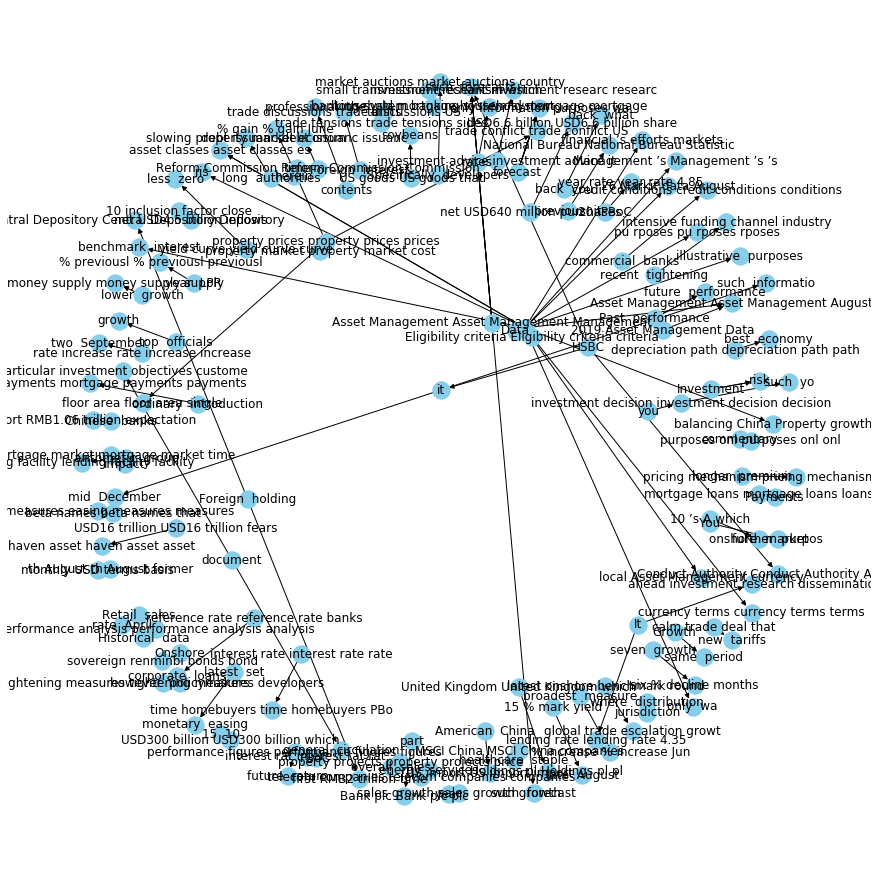

In [38]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

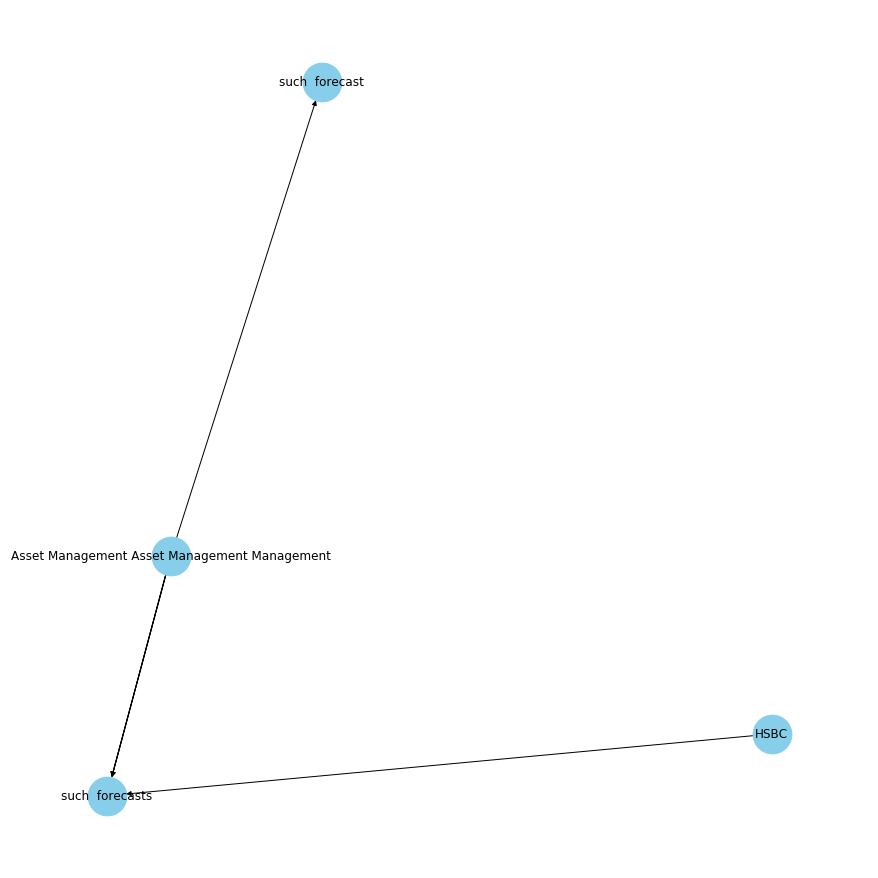

In [43]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="accepts"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()